In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import requests
import json
import quandl
import numpy as np
from math import radians, cos, sin, asin, sqrt
import xmltojson
from uszipcode import SearchEngine
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
##Zipcodes for California
engine = SearchEngine()
zipcodes_info = engine.by_state("california", returns=0)
zipcodes_CA = []
for zipcode in zipcodes_info:
    zipcodes_CA.append(zipcode.zipcode)

In [3]:
#Gathering real estate pricing by zipcode
##API Key for zillow data 
quandl.ApiConfig.api_key = 'ABH9PR2VkhsGBZDFG8X9'

##CA zip to region ID
region_ids = quandl.get_table('ZILLOW/REGIONS', paginate=True)

##delete non zips
zips_df= region_ids.loc[region_ids['region_type'] == "zip"]

##add column with ACUTAL zips
left = zips_df['region'].str[:5]
zips_df['zips'] = left

In [6]:
##California Zips to reigon ID converter:
regionsID_CA = []
for zipcode in zipcodes_CA:
    refrow = zips_df.loc[zips_df['zips'] == str(zipcode)]
    try:
        regionsID_CA.append(int(refrow['region_id']))
    except:
        pass

In [7]:
##Average Prices by zipcode
CA_avg_price = {}
for regionID in regionsID_CA:
    sale_prices = quandl.get_table('ZILLOW/DATA', indicator_id='Z3BR', region_id = regionID)
    sale_prices['date'] = pd.to_datetime(sale_prices['date'])
    include = sale_prices[sale_prices['date'].dt.year == 2020 ]
    values = include['value']
    CA_avg_price[regionID] = np.mean(values)

In [8]:
#making dictionary for region_ID to price
new_dict = {}
for k, v in CA_avg_price.items():
    if v > 0:
        new_dict[k] = v
regid_price = {k: v for k, v in sorted(new_dict.items(), key=lambda item: item[1], reverse=True)}

In [9]:
#making dictionary for CA zip codes and price
CA_zips_prices = {}
for regid, price in new_dict.items():
    zips_dfs = zips_df.loc[zips_df['region_id'] == str(regid)]
    zips = int(zips_dfs['zips'])
    CA_zips_prices[zips] = price

In [10]:
##Average price into bins of area (bins each 33% of price)
zip_price = {k: v for k, v in sorted(CA_zips_prices.items(), key=lambda item: item[1], reverse=True)}
zip_price_it = zip_price.items()

##3 bins
zip_price_bin1 = list(zip_price_it)[:int((len(zip_price)/3))]
zip_price_bin2 = list(zip_price_it)[int((len(zip_price)/3)):int((2*len(zip_price)/3))]
zip_price_bin3 = list(zip_price_it)[int((2*len(zip_price)/3)):]

bins = [zip_price_bin1, zip_price_bin2, zip_price_bin3]

#Gathering tesla superchargers location info
response = requests.get("https://supercharge.info/service/supercharge/allSites")
sc_info = response.json()
sc_locations = {}
for charger in sc_info:
    address = charger['address']
    if address['state'] == 'CA':
         sc_locations[charger['id']] = [charger['gps'], address['zip']]


In [61]:
##Proof of Concept
ids = sc_locations.keys()
tesla_zips = {}
for ID in ids:
    coord, zipcode = sc_locations[ID]
    if zipcode not in tesla_zips:
        tesla_zips[zipcode] = 1
    else:
        tesla_zips[zipcode] = tesla_zips[zipcode] + 1
for zipcode in zipcodes_CA:
    if zipcode not in tesla_zips:
        tesla_zips[zipcode] = 0

tesla_zips = {k: v for k, v in sorted(tesla_zips.items(), key=lambda item: item[1], reverse=True)}

#checking bins
pt_matches = []
for ref_bin in bins:
    matching_zips = 0
    for zc, price in ref_bin:
        matching_zips += tesla_zips[str(zc)]

    pt_matches.append(matching_zips / len(zip_price_bin1))

print("Bin 1 (high-end) has a ratio of:", pt_matches[0],
      "Bin 2 (CA Average) has a ratio of:", pt_matches[1],
      "Bin 3 (Below CA Average) has a ratio of:", pt_matches[2])

Bin 1 (high-end) has a ratio of: 0.4900662251655629 Bin 2 (CA Average) has a ratio of: 0.32781456953642385 Bin 3 (Below CA Average) has a ratio of: 0.2185430463576159


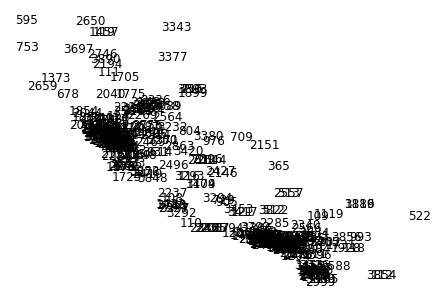

In [12]:
##Create initial network -- unconnected
G_original = nx.Graph()

ids = sc_locations.keys()
for ID in ids:
    coord, zipcode = sc_locations[ID]
    counter = 1
    for ref_bin in bins:
        for zips, price in ref_bin:
            if int(zipcode) == zips:
                classifier = counter
        counter += 1
    G_original.add_node(str(ID), pos= (coord['longitude'], coord['latitude']), price_classifier = classifier)

nx.draw(G_original, nx.get_node_attributes(G_original, 'pos'), with_labels=True, node_size=0)
plt.savefig("G_original.png")

In [13]:
##Distance from two points calculation
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3958.8 # Radius of earth in miles
    return c * r

In [14]:
##Distance from nodes
def add_edge_criteria(Graph, Distance):
    all_scs = G_original.nodes()   
    pos = nx.get_node_attributes(G_original, 'pos')
    for sc1 in all_scs:
        lat1, long1 = pos[str(sc1)]
        for sc2 in all_scs:
            if sc2 != sc1:
                lat2, long2 = pos[str(sc2)]
                dist = haversine(long1, lat1, long2, lat2)
                if (dist < Distance) and (Graph.has_edge(sc1, sc2) == False):
                    Graph.add_edge(sc1, sc2)

###Edges formed if charger is under 150 miles (half a full charge)
G1 = G_original.copy()
add_edge_criteria(G1, 150)
###Edges formed if a charger is under an hour drive (45 miles)
G2 = G_original.copy()
add_edge_criteria(G2, 45)
###Edges formed if charger under 15 miles apart from one another
G3 = G_original.copy()
add_edge_criteria(G3, 15)
###Edges formed if charger under 5 miles apart from one another 
G4 = G_original.copy()
add_edge_criteria(G4, 5)


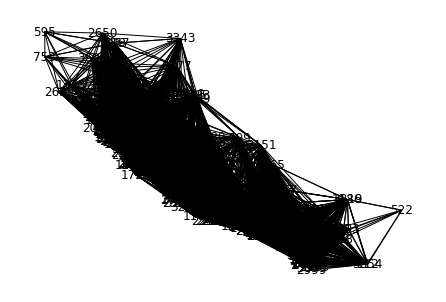

In [15]:
##150 miles edges formed
nx.draw(G1, nx.get_node_attributes(G_original, 'pos'), with_labels=True, node_size=0)
plt.savefig("G1.png")

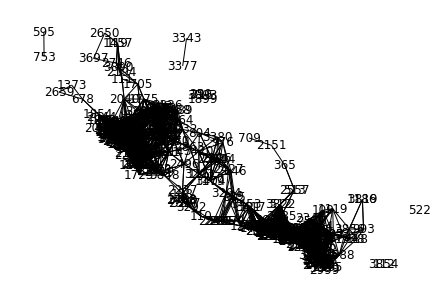

In [16]:
##45 miles edges formed
nx.draw(G2, nx.get_node_attributes(G_original, 'pos'), with_labels=True, node_size=0)
plt.savefig("G2.png")

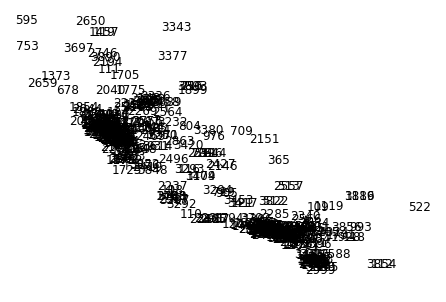

In [17]:
##15 miles edges formed
nx.draw(G3, nx.get_node_attributes(G_original, 'pos'), with_labels=True, node_size=0)
plt.savefig("G3.png")

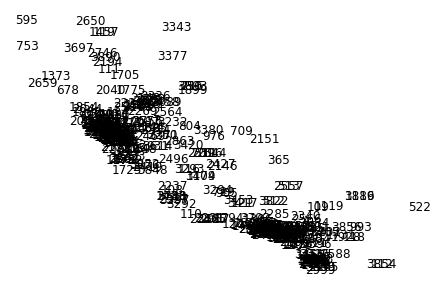

In [18]:
##5 miles edges formed
nx.draw(G4, nx.get_node_attributes(G_original, 'pos'), with_labels=True, node_size=0)
plt.savefig("G4.png")

In [19]:
print("G1:",nx.Graph.number_of_edges(G1), "edges,", "G2:",nx.Graph.number_of_edges(G2), 
      "edges,","G3:",nx.Graph.number_of_edges(G3), "edges,", "G4:",nx.Graph.number_of_edges(G4), "edges")

G1: 23953 edges, G2: 8144 edges, G3: 2211 edges, G4: 445 edges


In [20]:
list_graphs = [G1, G2, G3, G4]

In [21]:
###Check for proportionality between degree of node and price
def degree_price(G):
    all_scs = G.nodes()
    degrees = []
    price_classifier = nx.get_node_attributes(G, 'price_classifier')
    price_classifiers= []
    for sc in all_scs: 
        degree = G.degree[str(sc)]
        classifier = price_classifier[str(sc)]
        degrees.append(degree)
        price_classifiers.append(classifier)
    return degrees, price_classifiers

###Check for proportionality between betweenness centraility of nodes and price
def centr_price(G):
    all_scs = G.nodes()
    price_classifier = nx.get_node_attributes(G, 'price_classifier')
    bet_centrality = nx.betweenness_centrality(G)
    centralities = []
    price_classifiers= []
    for sc in all_scs: 
        centrality = bet_centrality[str(sc)]
        classifier = price_classifier[str(sc)]
        centralities.append(centrality)
        price_classifiers.append(classifier)
    return centralities, price_classifiers

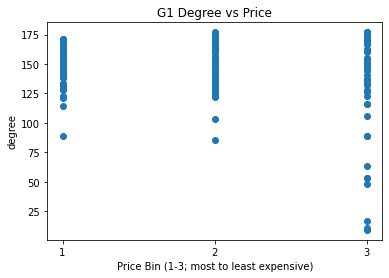

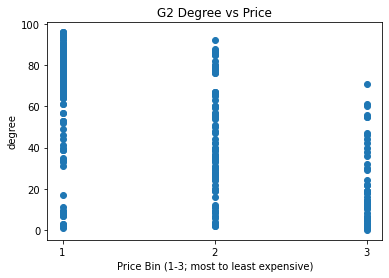

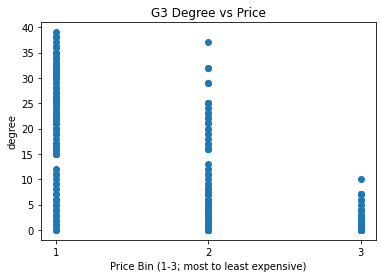

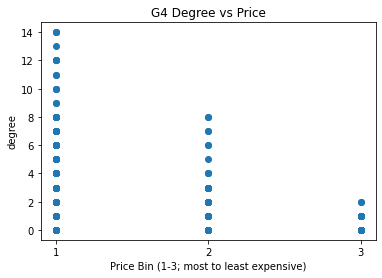

In [22]:
##Data for node degrees
for G in list_graphs:
    degs, classes = degree_price(G)
    plt.scatter(classes, degs)
    plt.title("G" + str(list_graphs.index(G) + 1) + ' Degree vs Price')
    plt.xlabel("Price Bin (1-3; most to least expensive)")
    plt.xticks([1,2,3])
    plt.ylabel("degree")
    plt.savefig("G" + str(list_graphs.index(G) + 1) + ' Degree' + '.png')
    plt.show()

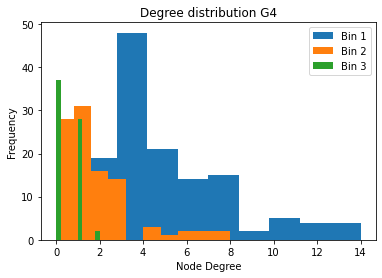

In [23]:
##Distribution of G4
class1 = []
class2 = [] 
class3 = []
classes = [class1, class2, class3]
degs, classes = degree_price(G4)
for indx in range(len(classes)):
    if classes[indx] == 1:
        class1.append(degs[indx])
    if classes[indx] == 2:
        class2.append(degs[indx])
    if classes[indx] == 3:
        class3.append(degs[indx])

plt.hist(class1)
plt.hist(class2)
plt.hist(class3)

plt.title("Degree distribution G4")
plt.xlabel("Node Degree")
plt.ylabel("Frequency")
plt.legend(("Bin 1", "Bin 2", "Bin 3"))
plt.savefig("DegreeDistributionG4.png")
plt.show()

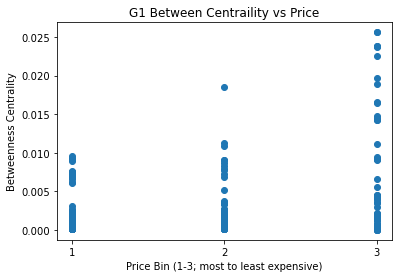

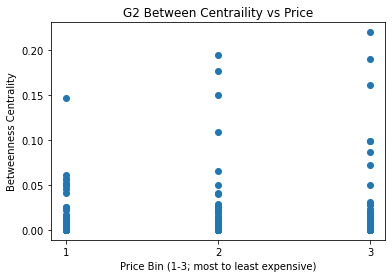

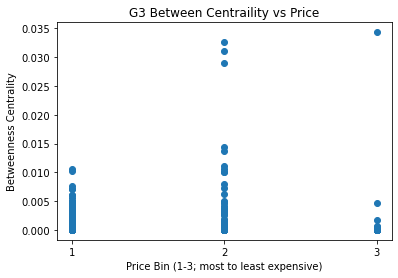

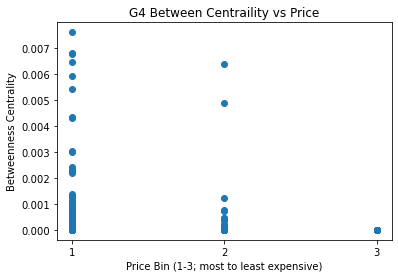

In [24]:
##Data for node centralities
for G in list_graphs:
    centr, classes = centr_price(G)
    plt.scatter(classes, centr)
    plt.title("G" + str(list_graphs.index(G) + 1) + ' Between Centraility vs Price')
    plt.xlabel("Price Bin (1-3; most to least expensive)")
    plt.xticks([1,2,3])
    plt.ylabel("Betweenness Centrality")
    plt.savefig("G" + str(list_graphs.index(G) + 1) + ' Between Centraility' + '.png')
    plt.show()

In [25]:
##Create dataframe for data
all_scs = G_original.nodes()   
sc_CA_df = pd.DataFrame()
sc_CA_df['Supercharger ID'] = all_scs
coords = []
temp_zips = []
ids = sc_locations.keys()
for ID in ids:
    coord, zips = sc_locations[ID]
    coords.append(coord)
    temp_zips.append(zips)
sc_CA_df['coordinates'] = coords
sc_CA_df['zip'] = temp_zips
sc_CA_df['degrees G1'], y = degree_price(G1)
sc_CA_df['degrees G2'], y = degree_price(G2)
sc_CA_df['degrees G3'], y = degree_price(G3)
sc_CA_df['degrees G4'], y = degree_price(G4)
sc_CA_df['Betweenness Centrality G1'], y = centr_price(G1)
sc_CA_df['Betweenness Centrality G2'], y = centr_price(G2)
sc_CA_df['Betweenness Centrality G3'], y = centr_price(G3)
sc_CA_df['Betweenness Centrality G4'], sc_CA_df['price_class'] = centr_price(G4)

# Simulation for Florida

In [26]:
##Zipcodes for Florida
zipcodes_info = engine.by_state("Florida", returns=0)
zipcodes_FL = []
for zipcode in zipcodes_info:
    zipcodes_FL.append(zipcode.zipcode)

In [27]:
##Tesla Superchargers in Florida:
sc_locations_FL = {}
for charger in sc_info:
    address = charger['address']
    if address['state'] == 'FL':
         sc_locations_FL[charger['id']] = [charger['gps'], address['zip']]

In [28]:
##Florida Zips to reigon ID converter:
regionsID_FL = []
for zipcode in zipcodes_FL:
    refrow = zips_df.loc[zips_df['zips'] == str(zipcode)]
    try:
        regionsID_FL.append(int(refrow['region_id']))
    except:
        pass

In [30]:
##Average Prices by zipcode
FL_avg_price = {}
for regionID in regionsID_FL:
    sale_prices = quandl.get_table('ZILLOW/DATA', indicator_id='Z3BR', region_id = regionID)
    sale_prices['date'] = pd.to_datetime(sale_prices['date'])
    include = sale_prices[sale_prices['date'].dt.year == 2020 ]
    values = include['value']
    FL_avg_price[regionID] = np.mean(values)

In [31]:
##create dictionary for region_id and price
new_dict = {}
for k, v in FL_avg_price.items():
    if v > 0:
        new_dict[k] = v
regid_price = {k: v for k, v in sorted(new_dict.items(), key=lambda item: item[1], reverse=True)}

In [32]:
FL_zips_prices = {}
for regid, price in new_dict.items():
    zips_dfs = zips_df.loc[zips_df['region_id'] == str(regid)]
    zips = int(zips_dfs['zips'])
    FL_zips_prices[zips] = price

In [33]:
##Average price into bins of area (bins each 20% of price)
zip_price = {k: v for k, v in sorted(FL_zips_prices.items(), key=lambda item: item[1], reverse=True)}
zip_price_it = zip_price.items()

##3 bins
zip_price_bin1 = list(zip_price_it)[:int((len(zip_price)/3))]
zip_price_bin2 = list(zip_price_it)[int((len(zip_price)/3)):int((2*len(zip_price)/3))]
zip_price_bin3 = list(zip_price_it)[int((2*len(zip_price)/3)):]

FL_bins = [zip_price_bin1, zip_price_bin2, zip_price_bin3]

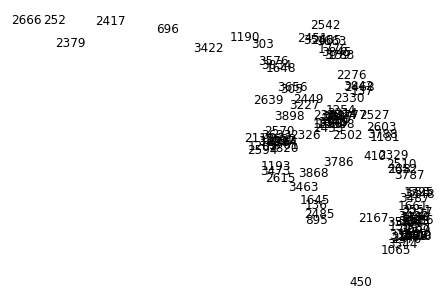

In [34]:
##Create Florida Unconnected network
G_FL = nx.Graph()

ids = sc_locations_FL.keys()
for ID in ids:
    coord, zipcode = sc_locations_FL[ID]
    counter = 1
    for ref_bin in FL_bins:
        for zips, price in ref_bin:
            if int(zipcode) == zips:
                classifier = counter
        counter += 1
    G_FL.add_node(str(ID), pos= (coord['longitude'], coord['latitude']), price_classifier = classifier)

nx.draw(G_FL, nx.get_node_attributes(G_FL, 'pos'), with_labels=True, node_size=0)
plt.savefig("GF.png")

In [35]:
##Distance from nodes
def add_edge_criteria(Graph, Distance):
    all_scs = G_FL.nodes()   
    pos = nx.get_node_attributes(G_FL, 'pos')
    for sc1 in all_scs:
        lat1, long1 = pos[str(sc1)]
        for sc2 in all_scs:
            if sc2 != sc1:
                lat2, long2 = pos[str(sc2)]
                dist = haversine(long1, lat1, long2, lat2)
                if (dist < Distance) and (Graph.has_edge(sc1, sc2) == False):
                    Graph.add_edge(sc1, sc2)

###Edges formed if charger is under 150 miles (half a full charge)
GF1 = G_FL.copy()
add_edge_criteria(GF1, 150)
###Edges formed if a charger is under an hour drive (45 miles)
GF2 = G_FL.copy()
add_edge_criteria(GF2, 45)
###Edges formed if charger under 15 miles apart from one another
GF3 = G_FL.copy()
add_edge_criteria(GF3, 15)
###Edges formed if charger under 5 miles apart from one another 
GF4 = G_FL.copy()
add_edge_criteria(GF4, 5)

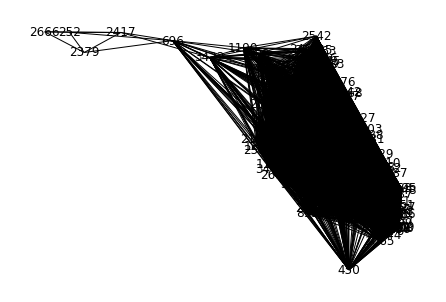

In [36]:
##150 miles edges formed
nx.draw(GF1, nx.get_node_attributes(G_FL, 'pos'), with_labels=True, node_size=0)
plt.savefig("GF1.png")

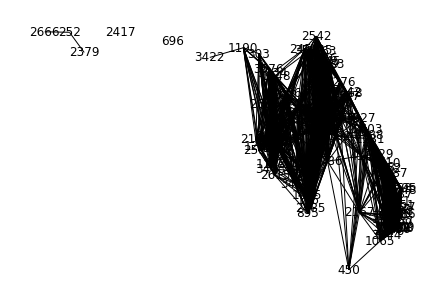

In [37]:
##45 miles edges formed
nx.draw(GF2, nx.get_node_attributes(G_FL, 'pos'), with_labels=True, node_size=0)
plt.savefig("GF2.png")

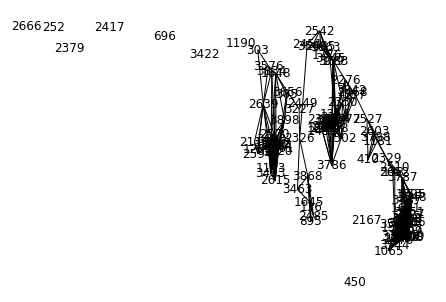

In [38]:
##15 miles edges formed
nx.draw(GF3, nx.get_node_attributes(G_FL, 'pos'), with_labels=True, node_size=0)
plt.savefig("GF3.png")

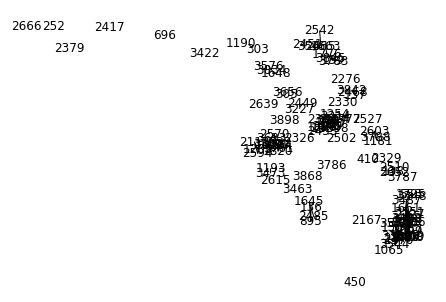

In [39]:
##5 miles edges formed
nx.draw(GF4, nx.get_node_attributes(G_FL, 'pos'), with_labels=True, node_size=0)
plt.savefig("GF4.png")

In [40]:
print("GF1:",nx.Graph.number_of_edges(GF1), "edges,", "GF2:",nx.Graph.number_of_edges(GF2), 
      "edges,","GF3:",nx.Graph.number_of_edges(GF3), "edges,", "GF4:",nx.Graph.number_of_edges(GF4), "edges")

GF1: 4819 edges, GF2: 1816 edges, GF3: 626 edges, GF4: 160 edges


In [41]:
list_graphs_FL = [GF1, GF2, GF3, GF4]

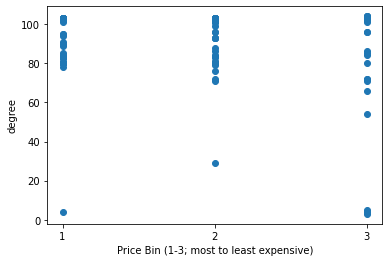

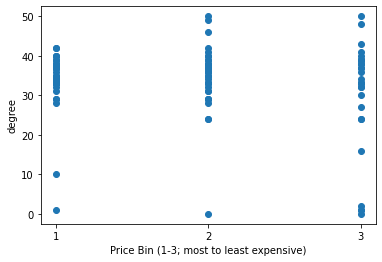

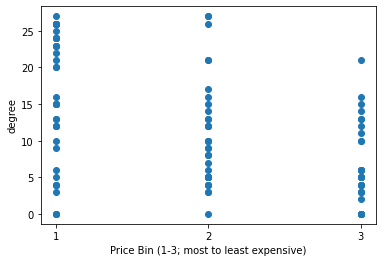

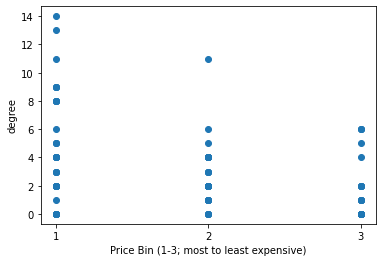

In [42]:
##Data for node degrees
for G in list_graphs_FL:
    degs, classes = degree_price(G)
    plt.scatter(classes, degs)
    plt.xlabel("Price Bin (1-3; most to least expensive)")
    plt.xticks([1,2,3])
    plt.ylabel("degree")
    plt.show()

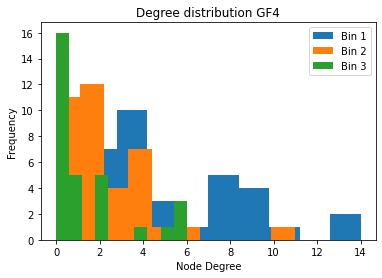

In [43]:
##Distribution of GF4
class1 = []
class2 = [] 
class3 = []
classes = [class1, class2, class3]
degs, classes = degree_price(GF4)
for indx in range(len(classes)):
    if classes[indx] == 1:
        class1.append(degs[indx])
    if classes[indx] == 2:
        class2.append(degs[indx])
    if classes[indx] == 3:
        class3.append(degs[indx])

plt.hist(class1)
plt.hist(class2)
plt.hist(class3)

plt.title("Degree distribution GF4")
plt.xlabel("Node Degree")
plt.ylabel("Frequency")
plt.legend(("Bin 1", "Bin 2", "Bin 3"))
plt.savefig("DegreeDistributionGF4.png")
plt.show()

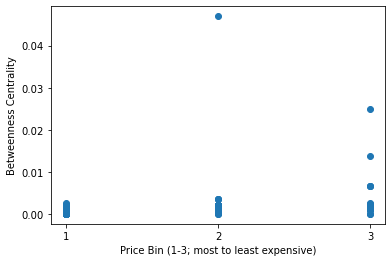

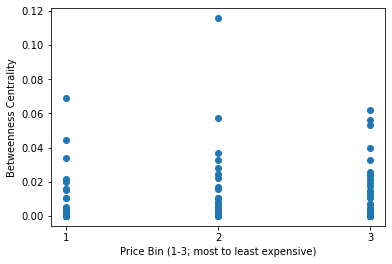

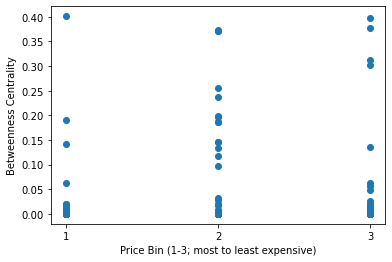

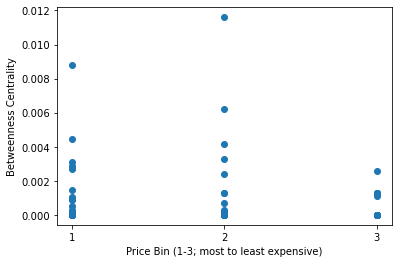

In [44]:
##Data for node centralities
for G in list_graphs_FL:
    centr, classes = centr_price(G)
    plt.scatter(classes, centr)
    plt.xlabel("Price Bin (1-3; most to least expensive)")
    plt.xticks([1,2,3])
    plt.ylabel("Betweenness Centrality")
    plt.show()

In [45]:
##Create dataframe for data
all_scs = G_FL.nodes()
sc_FL_df = pd.DataFrame()
sc_FL_df['Supercharger ID'] = all_scs
coords = []
temp_zips = []
ids = sc_locations_FL.keys()
for ID in ids:
    coord, zips = sc_locations_FL[ID]
    coords.append(coord)
    temp_zips.append(zips)
sc_FL_df['coordinates'] = coords
sc_FL_df['zip'] = temp_zips
sc_FL_df['degrees GF1'], y = degree_price(GF1)
sc_FL_df['degrees GF2'], y = degree_price(GF2)
sc_FL_df['degrees GF3'], y = degree_price(GF3)
sc_FL_df['degrees GF4'], y = degree_price(GF4)
sc_FL_df['Betweenness Centrality GF1'], y = centr_price(GF1)
sc_FL_df['Betweenness Centrality GF2'], y = centr_price(GF2)
sc_FL_df['Betweenness Centrality GF3'], y = centr_price(GF3)
sc_FL_df['Betweenness Centrality GF4'], sc_FL_df['price_class'] = centr_price(GF4)

# ML Model for training data Cali Test data Florida

In [51]:
##Training Sets
train, test = sc_CA_df, sc_FL_df

##Using only G4/GF4 degree and all of betweenness centrality (tested and is optimal given data collected)
X_train = train.iloc[:, 6:-1].values
y_train = train.iloc[:, 11].values

X_test = test.iloc[:, 6:-1].values
y_test = test.iloc[:, 11].values

In [52]:
##Scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
#ML Model classifer from imports
classifier = KNeighborsClassifier(n_neighbors=4)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [60]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[29 12  0]
 [ 9 27  1]
 [12 14  5]]
              precision    recall  f1-score   support

           1       0.58      0.71      0.64        41
           2       0.51      0.73      0.60        37
           3       0.83      0.16      0.27        31

    accuracy                           0.56       109
   macro avg       0.64      0.53      0.50       109
weighted avg       0.63      0.56      0.52       109



# Testing Accuracy of Results

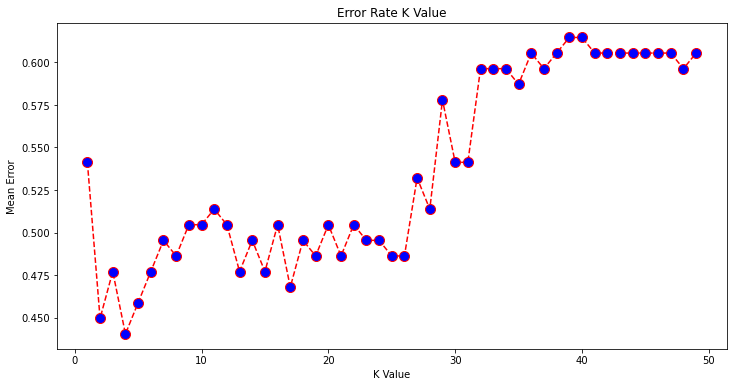

In [50]:
# Calculating error for K values between 1 and 50
error = []
for i in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 50), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.savefig("K_value_vs_Mean_Error.png")
plt.show()